In [16]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [105]:
from IPython.display import HTML
from sklearn import neighbors, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import os
from sklearn.utils.multiclass import unique_labels

n_neighbors = 10

Check working directory, probably in knearest folder. Change to cwd to src to acces the data easily

In [18]:
os.getcwd()

'C:\\Users\\danie\\Documents\\seminar\\src'

Move up one directory

In [5]:
%cd ..

C:\Users\danie\Documents\seminar\src


Load the data into numpy arrays

In [124]:
%%time
img = np.genfromtxt('data\images.csv', delimiter=',')
test = np.genfromtxt('data\images_test.csv', delimiter=',')

labels = np.genfromtxt('data\labels.csv', delimiter=',')
test_labels = np.genfromtxt('data\labels_test.csv', delimiter=',')

Wall time: 42.7 s


Apply k-fold crossvalidation

In [125]:
def k_fold(training_data,training_labels, k, n):
    observations = training_labels.size
    if observations%k != 0:
        print("Difficult division")
        return None
    foldsize = int(observations/k)
    validation_data = training_data[(n-1)*foldsize:n*foldsize]
    validation_labels = training_labels[(n-1)*foldsize:n*foldsize]
    new_training_data = np.concatenate((training_data[n*foldsize:],training_data[:(n-1)*foldsize]))
    new_training_labels = np.concatenate((training_labels[n*foldsize:],training_labels[:(n-1)*foldsize]))
    return validation_data, validation_labels, new_training_data, new_training_labels
fold1_val_data,fold1_val_labels,fold1_train_data, fold1_train_labels=k_fold(img,labels,5,5)

print(fold1_val_data.shape)
print(fold1_train_data.shape)



(12000, 784)
(48000, 784)


In [126]:
def log_progress(sequence, every=None, size=None, name='Folds'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

tag = HTML('''<script>
    code_show=true; 
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    function code_toggle() {
        if (code_show){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
        code_show = !code_show
    }     
    $( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()"><h4>Auxiliary progress bar and plotting function</h4></a>
''')
display(tag)

Create classifier instance, and train + predict the test data

In [127]:
%%time

#hyperparameter
n_folds = 5

#initialization
best_k = 1
best_hitrate = 0

#k fold loop, changing number of neighbors for every fold
for i in log_progress(range(n_folds)):
    n_neighbors = (i+1)
    test_fold,test_labels_fold,img_fold,labels_fold = k_fold(img,labels,n_folds,i+1)
    knn = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
    knn.fit(img_fold,labels_fold)
    predicted_fold = knn.predict(test_fold)
    hitrate = accuracy_score(predicted_fold,test_labels_fold)
    if hitrate> best_hitrate:
        best_hitrate = hitrate
        best_k = n_neighbors
print("Optimal number of neighbors:",best_k)
print("Corresponding hitrate",best_hitrate)


        

Optimal number of neighbors: 1
Corresponding hitrate 0.97
Wall time: 1h 5min 16s


In [128]:
%%time
#Fit on regular training and test set using optimal k
knn = neighbors.KNeighborsClassifier(best_k, weights='uniform')
knn.fit(img,labels)
predicted = knn.predict(test)

Wall time: 12min 45s


Create confusion matrix plotter @scilearndocs

Normalized confusion matrix
[[9.79859013e-01 0.00000000e+00 7.04934542e-03 0.00000000e+00
  0.00000000e+00 1.00704935e-03 4.02819738e-03 0.00000000e+00
  6.04229607e-03 2.01409869e-03]
 [8.56898029e-04 9.67437875e-01 5.14138817e-03 8.56898029e-04
  5.99828620e-03 8.56898029e-04 1.71379606e-03 1.19965724e-02
  8.56898029e-04 4.28449015e-03]
 [9.92063492e-04 2.97619048e-03 9.84126984e-01 1.98412698e-03
  0.00000000e+00 0.00000000e+00 0.00000000e+00 5.95238095e-03
  2.97619048e-03 9.92063492e-04]
 [0.00000000e+00 0.00000000e+00 4.95540139e-03 9.61347869e-01
  0.00000000e+00 1.18929633e-02 0.00000000e+00 1.98216056e-03
  1.38751239e-02 5.94648167e-03]
 [0.00000000e+00 1.02986612e-03 1.02986612e-03 1.02986612e-03
  9.72193615e-01 2.05973223e-03 3.08959835e-03 4.11946447e-03
  5.14933059e-03 1.02986612e-02]
 [1.10619469e-03 1.10619469e-03 0.00000000e+00 2.10176991e-02
  0.00000000e+00 9.51327434e-01 5.53097345e-03 0.00000000e+00
  1.43805310e-02 5.53097345e-03]
 [3.11850312e-03 1.03950104e-0

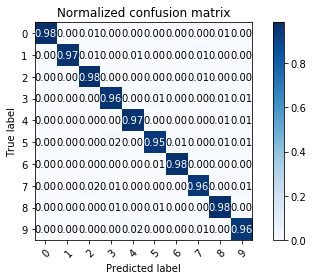

In [129]:
#plot results
# Plot normalized confusion matrix
plot_confusion_matrix(predicted, test_labels, classes=np.array([0,1,2,3,4,5,6,7,8,9]), normalize=True,
                      title='Normalized confusion matrix')
plt.show()

In [130]:
print("The accuracy of the model is {}".format(accuracy_score(predicted,test_labels)))

The accuracy of the model is 0.9691
